In [3]:
import torch
import os
torch.cuda.empty_cache()

In [4]:
os.environ["CUDA_LAUNCH_BLOCKING"] = "1"

In [ ]:
pip install transformers torch pdfplumber

In [1]:
import os
import torch
from torch import nn, optim
from transformers import CLIPProcessor, CLIPModel, BartForConditionalGeneration, BartTokenizer
import pdfplumber
import re
from PIL import Image

# Load CLIP model and processor
clip_model = CLIPModel.from_pretrained("openai/clip-vit-base-patch32").to("cuda" if torch.cuda.is_available() else "cpu")
clip_processor = CLIPProcessor.from_pretrained("openai/clip-vit-base-patch32")

# Load BART model and tokenizer
bart_model = BartForConditionalGeneration.from_pretrained("facebook/bart-large").to("cuda" if torch.cuda.is_available() else "cpu")
bart_tokenizer = BartTokenizer.from_pretrained("facebook/bart-large")

# PDF extraction function
def extract_text_and_image_from_pdf(pdf_path):
    extracted_text = ""
    images = []
    key_sections = ["abstract", "introduction", "methodology", "conclusion", "results"]
    with pdfplumber.open(pdf_path) as pdf:
        for page_number, page in enumerate(pdf.pages):
            page_text = page.extract_text()
            if not page_text:
                continue
            page_text = re.sub(r'\n+', ' ', page_text)
            lower_text = page_text.lower()
            for section in key_sections:
                pattern = rf"\b{section}\b"
                if re.search(pattern, lower_text):
                    extracted_text += page_text + "\n"
                    break
            if page.images:
                for image_info in page.images:
                    x0, y0, x1, y1 = image_info["x0"], image_info["top"], image_info["x1"], image_info["bottom"]
                    page_image = page.to_image()
                    cropped_image = page_image.original.crop((x0, y0, x1, y1))
                    images.append(cropped_image)
                break
    return extracted_text.strip(), images[0] if images else None

# CLIP + BART Fusion model
class CLIPBARTFusion(nn.Module):
    def __init__(self, bart_model, clip_dim=512, bart_dim=1024, max_seq_length=77):
        super(CLIPBARTFusion, self).__init__()
        self.bart_model = bart_model
        self.projection_layer = nn.Linear(clip_dim, bart_dim)
        self.max_seq_length = max_seq_length

    def forward(self, text_embeddings, image_embeddings):
        if text_embeddings.dim() == 2:
            text_embeddings = self.bart_model.get_input_embeddings()(text_embeddings)

        if image_embeddings.dim() == 2:
            image_embeddings = image_embeddings.unsqueeze(1)

        image_embeddings = self.projection_layer(image_embeddings)
        text_embeddings = self._adjust_sequence_length(text_embeddings)
        image_embeddings = self._adjust_sequence_length(image_embeddings)

        fused_embeddings = torch.cat((text_embeddings, image_embeddings), dim=1)
        return fused_embeddings

    def _adjust_sequence_length(self, embeddings):
        current_length = embeddings.size(1)
        if current_length > self.max_seq_length:
            return embeddings[:, :self.max_seq_length, :]
        else:
            padding = torch.zeros(
                (embeddings.size(0), self.max_seq_length - current_length, embeddings.size(2)),
                device=embeddings.device
            )
            return torch.cat((embeddings, padding), dim=1)

# Function to encode text and image with CLIP
def encode_with_clip(text, image):
    inputs = clip_processor(text=[text], images=image, return_tensors="pt", padding=True).to("cuda" if torch.cuda.is_available() else "cpu")
    outputs = clip_model(**inputs)
    text_embeddings = outputs.text_embeds
    image_embeddings = outputs.image_embeds
    return text_embeddings, image_embeddings

# Training setup
def train_model(dataset_folder, fusion_model, bart_tokenizer, num_epochs=20, learning_rate=1e-5):
    optimizer = optim.Adam(fusion_model.parameters(), lr=learning_rate)
    criterion = nn.CrossEntropyLoss()
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    fusion_model.to(device)
    
    pdf_paths = [os.path.join(dataset_folder, file) for file in os.listdir(dataset_folder) if file.endswith(".pdf")]

    for epoch in range(num_epochs):
        total_loss = 0
        for pdf_path in pdf_paths:
            text, image = extract_text_and_image_from_pdf(pdf_path)
            if not text:
                continue
            inputs = bart_tokenizer(text, return_tensors="pt", max_length=77, truncation=True, padding="max_length").to(device)
            text_embedding = inputs["input_ids"].to(device)
            image_input = clip_processor(images=image, return_tensors="pt").to(device)
            image_embedding = clip_model.get_image_features(**image_input).unsqueeze(1).to(device)
            
            fused_embeddings = fusion_model(text_embedding, image_embedding)
            target_ids = inputs["input_ids"].to(device)
            
            optimizer.zero_grad()
            outputs = fusion_model.bart_model(inputs_embeds=fused_embeddings, labels=target_ids)
            loss = criterion(outputs.logits.view(-1, outputs.logits.size(-1)), target_ids.view(-1))
            loss.backward()
            optimizer.step()
            
            total_loss += loss.item()
        
        print(f"Epoch {epoch + 1}/{num_epochs}, Loss: {total_loss / len(pdf_paths):.4f}")

# Path to dataset folder
dataset_folder = "capstone_project_dataset"

# Initialize and train the fusion model
fusion_model = CLIPBARTFusion(bart_model=bart_model, max_seq_length=128)
train_model(dataset_folder, fusion_model, bart_tokenizer)


2024-11-07 23:06:41.588801: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-11-07 23:06:42.456726: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
/home/dgxuser59/.local/lib/python3.8/site-packages/transformers/tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(


Epoch 1/20, Loss: 0.0244
Epoch 2/20, Loss: 0.0125
Epoch 3/20, Loss: 0.0048
Epoch 4/20, Loss: 0.0019
Epoch 5/20, Loss: 0.0009
Epoch 6/20, Loss: 0.0006
Epoch 7/20, Loss: 0.0004
Epoch 8/20, Loss: 0.0002
Epoch 9/20, Loss: 0.0001
Epoch 10/20, Loss: 0.0001
Epoch 11/20, Loss: 0.0001
Epoch 12/20, Loss: 0.0001
Epoch 13/20, Loss: 0.0001
Epoch 14/20, Loss: 0.0001
Epoch 15/20, Loss: 0.0001
Epoch 16/20, Loss: 0.0001
Epoch 17/20, Loss: 0.0001
Epoch 18/20, Loss: 0.0001
Epoch 19/20, Loss: 0.0001
Epoch 20/20, Loss: 0.0001


In [2]:
# Save model
torch.save(fusion_model.state_dict(), "clip_bart_fusion_model.pth")

# To load it later
fusion_model.load_state_dict(torch.load("clip_bart_fusion_model.pth"))

<All keys matched successfully>

In [3]:
import torch
from torch import nn
from transformers import CLIPProcessor, CLIPModel, BartForConditionalGeneration, BartTokenizer
import pdfplumber
import re
from rouge_score import rouge_scorer
from PIL import Image

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# Load CLIP and BART models
clip_model = CLIPModel.from_pretrained("openai/clip-vit-base-patch32").to(device)
clip_processor = CLIPProcessor.from_pretrained("openai/clip-vit-base-patch32")
bart_model = BartForConditionalGeneration.from_pretrained("facebook/bart-large").to(device)
bart_tokenizer = BartTokenizer.from_pretrained("facebook/bart-large")


class CLIPBARTFusion(nn.Module):
    def __init__(self, bart_model, clip_dim=512, bart_dim=1024, max_seq_length=77):
        super(CLIPBARTFusion, self).__init__()
        self.bart_model = bart_model
        self.projection_layer = nn.Linear(clip_dim, bart_dim)  # Project from CLIP's dimension to BART's dimension
        self.max_seq_length = max_seq_length

    def forward(self, text_embeddings, image_embeddings):
        if image_embeddings.dim() == 2:
            image_embeddings = image_embeddings.unsqueeze(1)
        image_embeddings = self.projection_layer(image_embeddings)
        fused_embeddings = torch.cat((text_embeddings, image_embeddings), dim=1)
        return fused_embeddings


# Initialize the fusion model
fusion_model = CLIPBARTFusion(bart_model=bart_model, max_seq_length=228).to(device)

# Load the model state
fusion_model.load_state_dict(torch.load("clip_bart_fusion_model.pth", map_location=device))
fusion_model.eval()

# Extract abstract and images from PDF
def extract_relevant_sections_and_images_from_pdf(pdf_path):
    with pdfplumber.open(pdf_path) as pdf:
        key_sections = ["abstract", "introduction", "methodology", "results"]
        extracted_text = ""
        extracted_images = []  # To store relevant images

        for page_num, page in enumerate(pdf.pages):
            page_text = page.extract_text()
            if not page_text:
                continue

            lower_text = page_text.lower()
            found_section = False
            # Check if any of the key sections are in the page text
            for section in key_sections:
                if section in lower_text:
                    extracted_text += f"--- {section.capitalize()} ---\n" + page_text + "\n"
                    found_section = True
                    break

            # Only extract images if a relevant section is found
            if found_section and page.images:
                for image_info in page.images:
                    x0, y0, x1, y1 = image_info["x0"], image_info["top"], image_info["x1"], image_info["bottom"]
                    page_image = page.to_image()
                    cropped_image = page_image.original.crop((x0, y0, x1, y1))
                    extracted_images.append(cropped_image)
                break  # Stop after extracting the first relevant image on the page

    return extracted_text.strip(), extracted_images


def summarize_pdf_abstract_and_evaluate(pdf_path, fusion_model, bart_tokenizer, max_length=300, num_beams=5):
    text, image = extract_relevant_sections_and_images_from_pdf(pdf_path)
    
    if not text:
        print("No relevant text found to summarize.")
        return "No Summary Generated", {"rouge1": 0, "rouge2": 0, "rougeL": 0}

    inputs = bart_tokenizer(text, return_tensors="pt", max_length=500, truncation=True, padding="max_length").to(device)
    text_embedding = bart_model.get_input_embeddings()(inputs["input_ids"])

    if image:
        image_input = clip_processor(images=image, return_tensors="pt").to(device)
        image_embedding = clip_model.get_image_features(**image_input).unsqueeze(1)
        fused_embeddings = fusion_model(text_embedding, image_embedding)
    else:
        fused_embeddings = text_embedding

    summary_ids = bart_model.generate(inputs_embeds=fused_embeddings, max_length=max_length, num_beams=num_beams, early_stopping=True)
    generated_summary = bart_tokenizer.decode(summary_ids[0], skip_special_tokens=True)

    reference_summary = """
    For efficient communication and learning in an area where Twi is
commonly spoken, it is imperative to have access to information in the
original tongue. In order to make information from Twi texts easier for
readers to understand and apply, this paper presents a novel way. Compressing a manuscript to highlight its key concepts is known as extraction
summary. We acknowledge that current approaches might not be suitable
for Twi, so we suggest a novel approach to improve the efficacy of extractive
summarization for this language. Our method makes use of certain Twi
language elements and subject-matter expertise to produce more accurate
summaries. This is crucial since it makes it easier for readers to immediately
understand the essential ideas of Twi papers. We tested our methodology
on a set of Twi texts, comparing our summaries to various approaches using a human evaluation process. Our findings demonstrate that, compared
to current techniques, our method generates more pertinent and accurate
summaries for Twi texts. We believe that this represents a positive move
towards making Twi content more accessible and usable. We illustrate the
usefulness of our approach in real-world contexts through case studies, including education, information retrieval, and digital content creation. We
think that by improving extractive summarization for Twi, we help increase
the value and accessibility of local language information for its speakers.
This research represents a progress in tackling the particular difficulties associated with information summarization in Twi. Our goal is to stimulate
additional study and breakthroughs in enhancing the accessibility of information in African languages by concentrating on linguistic aspects and
domain-specific expertise.
    """
    scorer = rouge_scorer.RougeScorer(['rouge1', 'rouge2', 'rougeL'], use_stemmer=True)
    scores = scorer.score(reference_summary, generated_summary)

    return generated_summary, scores

# Summarize the PDF
pdf_path = "ENHANCING_EXTRACTIVE_SUMMARIZATION_FOR_TWI_TEXTS_.pdf"  # Replace with the path to your PDF
summary, rouge_scores = summarize_pdf_abstract_and_evaluate(pdf_path, fusion_model, bart_tokenizer)

# Output
print("Generated Summary:", summary)
print("ROUGE Scores:", rouge_scores)

Using device: cuda
Generated Summary: --- Abstract ---                0.1 ABSTRACT                ffiSourceFileFor e cient communication and learning in an area where Twi is                commonly spoken, it is imperative to have access to information in the                original tongue. In order to make information from Twi texts easier for                readers to understand and apply, this paper presents a novel way. Com-SourceFilepressing a manuscript to highlight its key concepts is known as extraction*/(summary. Thisiscrucialsinceitmakesiteasierforreaderstoimmediatelycffffunderstand the essential ideas of Twi papers. We acknowledge that current approaches might not be suitable�ffi*/(forTwi,sowesuggestanovelapproachtoimprovethee cacyofextractiveSourceFilesummarization for this language. Our method makes use of certain TwiSourceFilelanguage elements and subject-matter expertise to produce more accurateSourceFilesummaries. We illustrate theSourceFileusefulness of our approach in

In [12]:
import torch
from torch import nn
from transformers import CLIPProcessor, CLIPModel, BartForConditionalGeneration, BartTokenizer
import pdfplumber
import re
from rouge_score import rouge_scorer
from PIL import Image

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# Load models
clip_model = CLIPModel.from_pretrained("openai/clip-vit-base-patch32").to(device)
clip_processor = CLIPProcessor.from_pretrained("openai/clip-vit-base-patch32")
bart_model = BartForConditionalGeneration.from_pretrained("facebook/bart-large").to(device)
bart_tokenizer = BartTokenizer.from_pretrained("facebook/bart-large")

# Fusion model definition and loading
class CLIPBARTFusion(nn.Module):
    def __init__(self, bart_model, clip_dim=512, bart_dim=1024, max_seq_length=128):
        super(CLIPBARTFusion, self).__init__()
        self.bart_model = bart_model
        self.projection_layer = nn.Linear(clip_dim, bart_dim)

    def forward(self, text_embeddings, image_embeddings):
        image_embeddings = self.projection_layer(image_embeddings)
        fused_embeddings = torch.cat((text_embeddings, image_embeddings), dim=1)
        return fused_embeddings

fusion_model = CLIPBARTFusion(bart_model=bart_model).to(device)
fusion_model.load_state_dict(torch.load("clip_bart_fusion_model.pth", map_location=device))
fusion_model.eval()
print("Loaded saved fusion model.")

# Updated text/image extraction
def extract_text_and_image_from_pdf(pdf_path):
    extracted_text = ""
    images = []
    key_sections = ["abstract", "introduction", "methodology", "results"]
    ignore_sections = ["table of contents"]
    start_page = 3

    with pdfplumber.open(pdf_path) as pdf:
        for page_num, page in enumerate(pdf.pages):
            if page_num < start_page:
                continue

            page_text = page.extract_text()
            if not page_text:
                continue

            lower_text = page_text.lower()
            if any(section in lower_text for section in ignore_sections):
                print(f"Skipping table of contents on page {page_num + 1}")
                continue

            for section in key_sections:
                if section in lower_text:
                    print(f"Found section '{section}' on page {page_num + 1}")
                    extracted_text += page_text + "\n"
                    break

            if page.images:
                for image_info in page.images:
                    x0, y0, x1, y1 = image_info["x0"], image_info["top"], image_info["x1"], image_info["bottom"]
                    page_image = page.to_image()
                    cropped_image = page_image.original.crop((x0, y0, x1, y1))
                    images.append(cropped_image)
                break  # Stop after the first relevant image

    if not extracted_text.strip():
        print("No key sections found. Using fallback extraction from initial pages.")
        extracted_text = "\n".join(page.extract_text() for page in pdf.pages[:2] if page.extract_text())
    return extracted_text.strip(), images[0] if images else None

# Encoding and summarization
def encode_with_clip(text, image):
    inputs = clip_processor(text=[text], images=image, return_tensors="pt", padding=True).to(device)
    outputs = clip_model(**inputs)
    return outputs.text_embeds, outputs.image_embeds

def generate_summary(fusion_model, bart_tokenizer, input_text_embeddings, input_image_embeddings, max_length=300):
    fused_embeddings = fusion_model(input_text_embeddings, input_image_embeddings)
    summary_ids = fusion_model.bart_model.generate(inputs_embeds=fused_embeddings, max_length=max_length)
    return bart_tokenizer.decode(summary_ids[0], skip_special_tokens=True)

# Run the summarization process
def summarize_pdf(pdf_path, fusion_model, bart_tokenizer, max_length=300):
    text, image = extract_text_and_image_from_pdf(pdf_path)
    if not text:
        print("No relevant text found to summarize.")
        return "No Summary Generated"

    inputs = bart_tokenizer(text, return_tensors="pt", max_length=500, truncation=True, padding="max_length").to(device)
    text_embedding = bart_model.get_input_embeddings()(inputs["input_ids"])
    
    if image:
        image_input = clip_processor(images=image, return_tensors="pt").to(device)
        image_embedding = clip_model.get_image_features(**image_input).unsqueeze(1)
        summary = generate_summary(fusion_model, bart_tokenizer, text_embedding, image_embedding, max_length)
    else:
        summary = generate_summary(fusion_model, bart_tokenizer, text_embedding, text_embedding, max_length)

    return summary

# Example usage
pdf_path = "_capstone AD .docx - Ankalla George Witfield _ AP20110010776.pdf"
summary = summarize_pdf(pdf_path, fusion_model, bart_tokenizer)
print("Generated Summary:", summary)

Using device: cuda
Loaded saved fusion model.
Found section 'abstract' on page 6
Skipping table of contents on page 7
Found section 'introduction' on page 11
Found section 'methodology' on page 12
Found section 'methodology' on page 13
Generated Summary: Abstract                Alzheimer's disease (AD) is a neurological illness that affects millions ofSourceFilepeople globally. Early detection and classification of AD stages areݚcrucial for effective management and treatment. This project proposes                An innovative method for categorizing Alzheimer's illness stages using*/(the You Only Look Once version 8 (YOLOv8) object detection algorithm.in classifying ADSTDOUTstages, demonstrating its effectiveness in early Alzheimer's disease*/(diagnosis and categorization. TheSourceFile90% accuracy rate is attained by the trained model. Preprocessing methods like image normalization and*/(enhancement are applied to enhance The performance of the model. The performanceof the model is fu

Extracted Text: --- Abstract ---
0.1 ABSTRACT
ffi
For e cient communication and learning in an area where Twi is
commonly spoken, it is imperative to have access to information in the
original tongue. In order to make information from Twi texts easier for
readers to understand and apply, this paper presents a novel way. Com-
pressing a manuscript to highlight its key concepts is known as extraction
summary. We acknowledge that current approaches might not be suitable
ffi
forTwi,sowesuggestanovelapproachtoimprovethee cacyofextractive
summarization for this language. Our method makes use of certain Twi
language elements and subject-matter expertise to produce more accurate
summaries. Thisiscrucialsinceitmakesiteasierforreaderstoimmediately
understand the essential ideas of Twi papers. We tested our methodology
on a set of Twi texts, comparing our summaries to various approaches us-
ing a human evaluation process. Our findings demonstrate that, compared
to current techniques, our method g

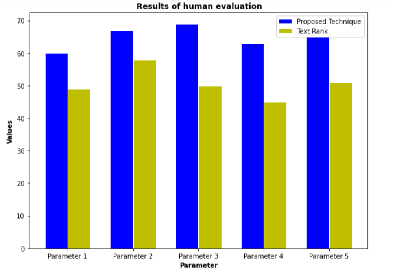

In [11]:
import pdfplumber
import re

def extract_relevant_text_and_images(pdf_path):
    with pdfplumber.open(pdf_path) as pdf:
        key_sections = ["abstract", "introduction", "methodology", "results"]
        extracted_text = ""
        extracted_images = []  # To store relevant images

        for page_num, page in enumerate(pdf.pages):
            page_text = page.extract_text()
            if not page_text:
                continue

            lower_text = page_text.lower()
            found_section = False
            # Check if any of the key sections are in the page text
            for section in key_sections:
                if section in lower_text:
                    extracted_text += f"--- {section.capitalize()} ---\n" + page_text + "\n"
                    found_section = True
                    break

            # Only extract images if a relevant section is found
            if found_section and page.images:
                for image_info in page.images:
                    x0, y0, x1, y1 = image_info["x0"], image_info["top"], image_info["x1"], image_info["bottom"]
                    page_image = page.to_image()
                    cropped_image = page_image.original.crop((x0, y0, x1, y1))
                    extracted_images.append(cropped_image)
                break  # Stop after extracting the first relevant image on the page

    return extracted_text.strip(), extracted_images

# Example usage
pdf_path = "ENHANCING_EXTRACTIVE_SUMMARIZATION_FOR_TWI_TEXTS_.pdf"  # Replace with the actual path to your PDF
text, images = extract_relevant_text_and_images(pdf_path)

print("Extracted Text:", text)
if images:
    print(f"Number of images extracted: {len(images)}")
    images[0].show()  # Display the first extracted image
else:
    print("No images extracted.")

In [74]:
import pdfplumber
import re

def extract_specified_sections(pdf_path, section_titles):
    extracted_content = {}
    with pdfplumber.open(pdf_path) as pdf:
        full_text = ""
        for page in pdf.pages:
            full_text += page.extract_text() + "\n"  # Extract and add text from each page

    # Loop through each section title we want to extract
    for title in section_titles:
        # Regex pattern to match the section and capture content until the next specified title or end of text
        pattern = re.compile(r"(?i)(?<=\n)\b{}\b\s*([\s\S]*?)(?=\n\b(?:{})\b|\Z)".format(
            re.escape(title),
            "|".join(map(re.escape, section_titles))
        ), re.DOTALL)
        
        # Search for the specific section content
        match = pattern.search(full_text)
        if match:
            # Get and clean up the matched content
            content = match.group(1).strip()

            # Remove common table of contents or list patterns
            content = re.sub(r"(\n\d+\.\s*|\n\d+\.\d+|\nList of Figures|\n\d+\s*\.\s*\w+|\n[\d\w]+\s*\.+\d+|\nFigure\s+\d+\.\d+)", "", content)
            content = re.sub(r"\.{3,}", "", content)  # Remove dotted lines
            content = re.sub(r"\s{2,}", " ", content)  # Remove excessive whitespace
            content = re.sub(r"\n\s*\n", "\n", content)  # Remove extra blank lines
            
            # Add the cleaned content to the dictionary for this section title
            extracted_content[title] = content

    return extracted_content

# Define the path to your PDF and the sections you want to extract
pdf_path = "_capstone AD .docx - Ankalla George Witfield _ AP20110010776.pdf"
section_titles = ["Abstract", "Introduction", "Methodology", "Conclusion"]

# Extract content
sections = extract_specified_sections(pdf_path, section_titles)

# Print the extracted sections
for title, content in sections.items():
    print(f"{title}:\n{content}\n")

Abstract:
Alzheimer's disease (AD) is a neurological illness that affects millions of
people globally. Early detection and classification of AD stages are
crucial for effective management and treatment. This project proposes
An innovative method for categorizing Alzheimer's illness stages using
the You Only Look Once version 8 (YOLOv8) object detection algorithm.
The dataset used contains images representing four stages of
Alzheimer's disease: mild demented, very mild demented, moderate
demented, and non-demented.
The YOLOv8 algorithm is trained to detect and classify these stages in
brain MRI images. Preprocessing methods like image normalization and
enhancement are applied to enhance The performance of the model. The
90% accuracy rate is attained by the trained model.in classifying AD
stages, demonstrating its effectiveness in early Alzheimer's disease
diagnosis and categorization. This project helps to further the field of
medical image analysis using deep learning techniques and sh

Abstract:
Alzheimer's disease (AD) is a neurological illness that affects millions of
people globally. Early detection and classification of AD stages are
crucial for effective management and treatment. This project proposes
An innovative method for categorizing Alzheimer's illness stages using
the You Only Look Once version 8 (YOLOv8) object detection algorithm.
The dataset used contains images representing four stages of
Alzheimer's disease: mild demented, very mild demented, moderate
demented, and non-demented.
The YOLOv8 algorithm is trained to detect and classify these stages in
brain MRI images. Preprocessing methods like image normalization and
enhancement are applied to enhance The performance of the model. The
90% accuracy rate is attained by the trained model.in classifying AD
stages, demonstrating its effectiveness in early Alzheimer's disease
diagnosis and categorization. This project helps to further the field of
medical image analysis using deep learning techniques and sh

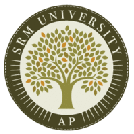

Displaying image 2


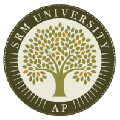

Displaying image 3


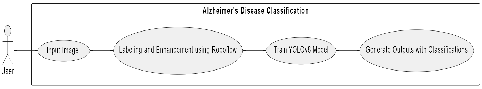

Displaying image 4


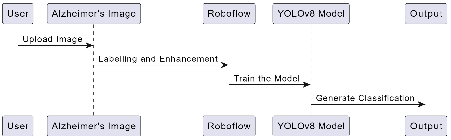

Displaying image 5


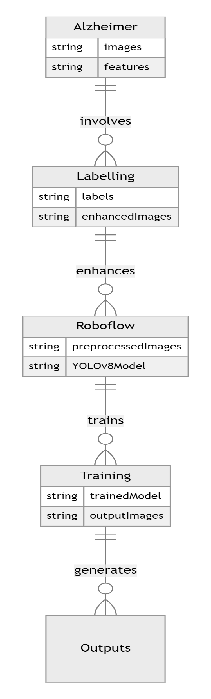

Displaying image 6


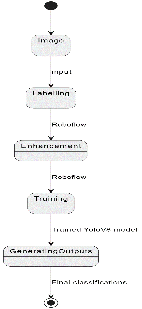

Displaying image 7


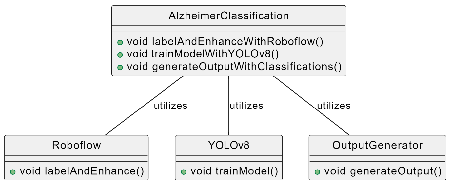

Displaying image 8


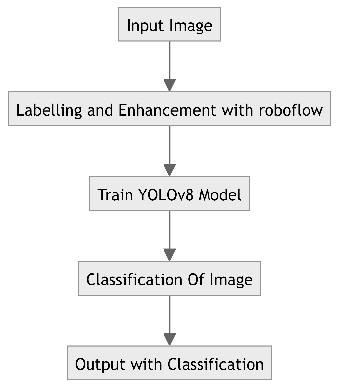

Displaying image 9


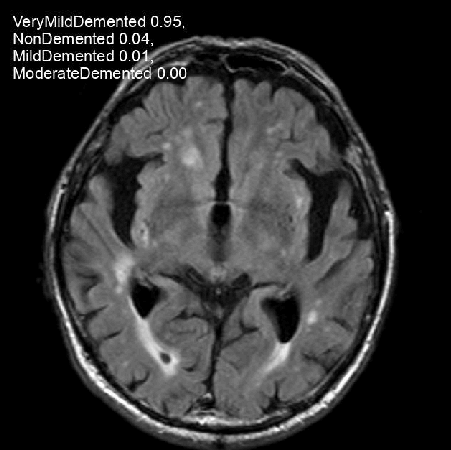

Displaying image 10


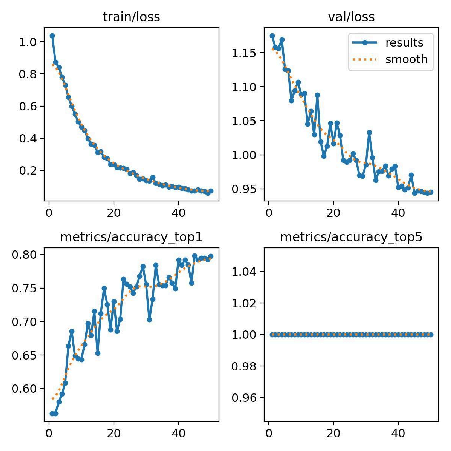

In [78]:
import pdfplumber
import re
from PIL import Image

def extract_text_and_all_images(pdf_path, section_titles):
    extracted_content = {}
    images = []
    
    with pdfplumber.open(pdf_path) as pdf:
        full_text = ""
        
        # Extract all text from the PDF and store all images
        for page in pdf.pages:
            full_text += page.extract_text() + "\n"  # Extract and add text from each page

            # Extract all images on the page
            if page.images:
                for image in page.images:
                    # Get the coordinates of the image
                    x0, y0, x1, y1 = image["x0"], image["top"], image["x1"], image["bottom"]
                    # Convert the page to an image and crop around the image coordinates
                    page_image = page.to_image()
                    cropped_image = page_image.original.crop((x0, y0, x1, y1))
                    images.append(cropped_image)  # Add each cropped image to the images list

    # Extract specific sections from full text
    for title in section_titles:
        # Regex pattern to match section content until the next section or end of document
        pattern = re.compile(r"(?i)(?<=\n)\b{}\b\s*([\s\S]*?)(?=\n\b(?:{})\b|\Z)".format(
            re.escape(title),
            "|".join(map(re.escape, section_titles))
        ), re.DOTALL)
        
        # Search and clean up the matched content
        match = pattern.search(full_text)
        if match:
            content = match.group(1).strip()
            # Remove table of contents and unnecessary patterns
            content = re.sub(r"(\n\d+\.\s*|\n\d+\.\d+|\nList of Figures|\n\d+\s*\.\s*\w+|\n[\d\w]+\s*\.+\d+|\nFigure\s+\d+\.\d+)", "", content)
            content = re.sub(r"\.{3,}", "", content)  # Remove dotted lines
            content = re.sub(r"\s{2,}", " ", content)  # Remove excessive whitespace
            content = re.sub(r"\n\s*\n", "\n", content)  # Remove extra blank lines
            
            extracted_content[title] = content

    return extracted_content, images

# Define the path to your PDF and the sections you want to extract
pdf_path = "_capstone AD .docx - Ankalla George Witfield _ AP20110010776.pdf"
section_titles = ["Abstract", "Introduction", "Methodology", "Conclusion"]

# Extract content and all images
sections, images = extract_text_and_all_images(pdf_path, section_titles)

# Print the extracted sections
for title, content in sections.items():
    print(f"{title}:\n{content}\n")

# Display all images if found
if images:
    for idx, img in enumerate(images):
        print(f"Displaying image {idx + 1}")
        img.show()  # This will open each image in a viewer
else:
    print("No images found.")